## Домашнее задание 11, SVM.
### Deadline -  29.11.2024    


## Основная часть

Для работы домашнего задания, необходимо загрузить файл svm.py по тому же пути, по которому лежит этот файл.

Эта домашняя работа будет отличаться от предыдущих и ее идея показать и рассказать как рабобоает SVM с разными методами нахождения оптимума. Поэтому в этой работе не будет заданий по написанию большой части кода или вывода двойстенных задач.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification, make_circles
from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel

pd.options.display.max_columns = 200
import svm
from svm import SVM, visualize
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import seaborn as sns
import matplotlib

sns.set_theme(palette='Set2', rc={'figure.figsize': (16, 9)})
matplotlib.rcParams['figure.figsize'] = (16, 9)


def make_plot(xlabex: str, ylabel: str, title: str = "Plot", xlim: list = None, ylim: list = None, **kwargs) -> (
        plt.figure, plt.axis):
    """
    Creates a plot with the following parameters
    
    :param xlabex: x-axis label
    :param ylabel: y-axis label
    :param title: plot title
    :param xlim: x-limits
    :param ylim: y-limits
    """
    fig_, axs_ = plt.subplots(**kwargs)

    axs_.set_xlabel(xlabex)
    axs_.set_ylabel(ylabel)
    axs_.set_title(title)

    if xlim is not None:
        axs_.set_xlim(xlim)
    if ylim is not None:
        axs_.set_ylim(ylim)

    return fig_, axs_

## Введение в SVM

Пусть перед нами стоит задачи банарной классификации. Будем считать, что $y_i \in \{ -1, 1\}; \quad y \in \mathbb{R}^d$.

Запишем нашу первоначальную задачу в виде задачи нахождения разделяющей гиперплоскости:
$$
    \begin{cases}
        \omega x_i + b \geqslant 1, \quad y_i = 1 \\
        \omega x_i + b < 1, \quad y_i = -1
    \end{cases}
$$.
Запишем задачу формально:
$$
    \sum_{i} \mathbb{I} \left[ y_i \not = sign( \langle \omega, x_i \rangle + b) \right] \rightarrow \min_{\omega}\\
    \sum_{i} \mathbb{I} \left[ y_i ( \langle \omega, x_i \rangle + b) < 0\right] \rightarrow \min_{\omega}
$$

Велечина $M = y_i ( \langle \omega, x_i \rangle + b)$ называется отступом классификатора. Легко увидеть, что 
1) Отступ положителен, когда $sign(y_i) = sing(\langle \omega, x_i \rangle + b)$, то есть класс угадан верно. При этом чем больше отступ, тем больше расстояние от $x_i$ до разделяющей гиперплоскости
2) Отступ отрицателен, когда $sign(y_i) \not = sing(\langle \omega, x_i \rangle + b)$, то есть класс угадан неверно. При этом чем больше отступ, тем больше ошибается классификатор.


В некоторых случаях гиперплоскость можно расположить несколькими способами. Поэтому возникает логичное желание не только найти разделяющую прямую, а еще и провести ее на одинаковом удалении от обоих классов, то есть максимизировать минимальный отступ.

Это можно сделать, положив функцию ошибки равной $max(0, 1 - M)$. Добавим к задаче $L_2$ регуляризацию и получим следующую задачу:
$$
    \frac{1}{2}||\omega||^2 + C\sum_{i} \max (0, 1 - y_i ( \langle \omega, x_i \rangle + b)) \rightarrow \min_{\omega}
$$

Также легко к этой задаче можно найти двойственную, что Вы уже проделывали в домашнем задании 9. На всякий случай запишем и двойственную задачу:
$$
    -\sum_{i=1}^d \lambda_i + \frac{1}{2}\sum_{i=1}^{d}\sum_{j=1}^{d} \lambda_i\lambda_j y_iy_j\langle x_i, x_j \rangle \rightarrow \min_{\lambda}\\
    s.t. \quad 0 \leqslant \lambda_i \leqslant C, \quad i = 1,...,d;\\
    \sum_{i=1}^d \lambda_iy_i = 0
$$

__Hint__: На самом деле эта задача двойственная к немного другой, если хотите строгого теоретического вывода, то посмотрите [презентацию К.В.Воронцова](http://machinelearning.ru/wiki/images/archive/a/a0/20150316112120!Voron-ML-Lin-SVM.pdf)

__Задача 1. (всего 2.5 балла)__ Сравнение различных способов нахождения решения линейных задачи.

В библиотеке реализованы следующие методы решения задачи SVM:
1) Метод внутренней точки для решения прямой задачи
2) Метод внутренней точки для решения двойственной задачи
3) Метод субградиентного спуска для решения прямой задачи
4) Метод стохастического субградиентного спуска для решения прямой задачи
5) Метод liblinear из библиотеки liblinear (решает задачи оптимизации путем последовательного выполнения приближенной минимизации вдоль координатных направлений или координатных гиперплоскостей)
6) Метод libsvm из библиотеки libsvm (решает задачу оптимизации путем разбиения задачи на ряд наименьших возможных подзадач, которые затем решаются аналитически)

__а). (1 балл)__ Сравнение временной сложности способов в зависимости от размерности. 

В этой задаче вам предстоит выбрать размерности, на которых будут сравниваться методы, дописать недостающих код и вывести на график зависимость времени работы от размерности задачи.

Рекомендуем выбрать как минимум 10 различных размерностей из отрезка [50, 1000].

In [3]:
import time


def get_time(model, X, y):
    start_time = time.time()
    model.fit(X, y)
    return time.time() - start_time


def generate_dataset(n_samples: int, dim: int, rnd=4202):
    return make_classification(n_samples=n_samples, n_features=int(dim * 1.2), n_informative=dim, random_state=rnd)


In [4]:
models = {'Pclf': SVM(method='primal'),
          'Dclf': SVM(method='dual', kernel='linear'),
          'Sclf': SVM(method='subgradient'),
          'StochSclf': SVM(method='stoch_subgradient'),
          'LLclf': SVM(method='liblinear'),
          'LSclf': SVM(method='libsvm', kernel='linear')}

times = {'Pclf': [],
         'Dclf': [],
         'Sclf': [],
         'StochSclf': [],
         'LLclf': [],
         'LSclf': []}

rng = np.random.default_rng(4202)

N = 300  # рекомендуемое количество n_samples в генерации датасета
D_array = np.linspace(50, 1000, 15).astype('int')  # размерности задач

for D in D_array:
    X, y = generate_dataset(N, D)
    y = y[:, np.newaxis]

    for key, val in models.items():
        times[key].append(get_time(val, X, y))

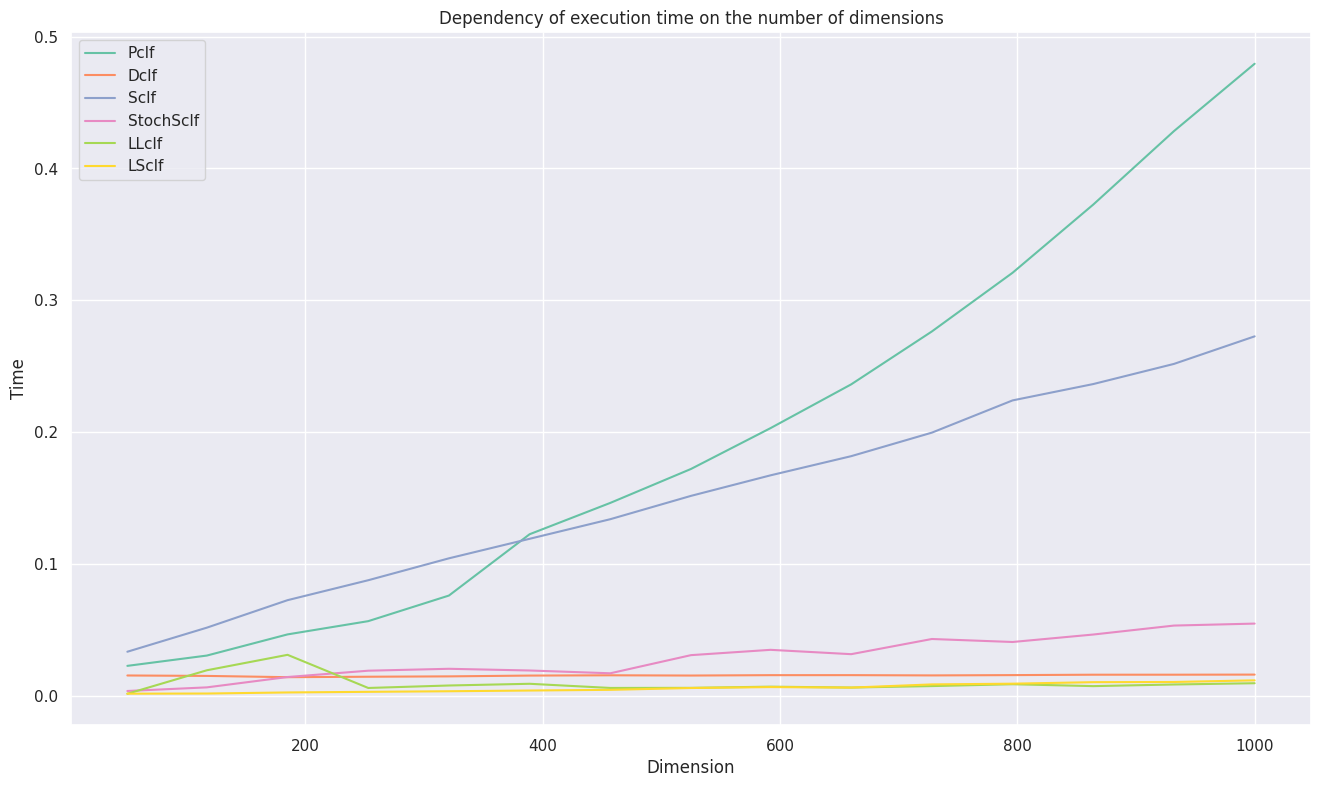

In [5]:
axs = make_plot("Dimension", "Time", "Dependency of execution time on the number of dimensions")[1]
for key, val in times.items():
    sns.lineplot(x=D_array, y=val, label=key)
plt.show()

__Ваше решение__ 

Опишите наблюдаемые на графиках результаты. Как думаете, почему они такие?

1) Метод внутренней точки для прямой задачи содержит в себе матрицу $n$ на $d$, потому сложность растет пропорционально d с большим коэффициентом. При высоких размерностях стоимость вычислений увеличивается
2) Субграниентный спуск для решения прямой задачи так же тратит много вычислительной мощности на вычисления градиентов, но уже значительно меньше в силу отсутствия прямого перемножения и итераций с полными матрицами большой размерности
3) Метод стохастической оптимизации для решения прямой задачи уже делит на батчи и избавляется от большой константы $n$, заменяя ее на размер батча, потому работает существенно быстрее
4) Решение двойственной задачи существенно ускоряет работу, так как происходит переход к двойственным переменным, вычисления с которыми ощутимо быстрее, чем с изначальными параметрами (двойственная задача внутри себя имеет суммирование по от $n$, без использования $d$), в силу чего мы получаем почти константное время
5) Предполагаю, что методы из библиотек очень хорошо оптимизированы и потому дают результаты по скорости сильно лучше, чем уже перечисленныем методы, из-за чего выполнение приближенной минимизации и разбиеня на ряд наименьших возможных задач побеждают в скорости

__б). (1.5 балла)__ Сравнение временной сложности способов в зависимости от количества элементов. 

В этой задаче вам предстоит выбрать количество элементов в датасете, на котором будут сравниваться методы, и вывести на график зависимость времени работы от количества элементов в датасете.

Рекомендуем выбрать как минимум 10 различных значений из отрезка [300, 1500].

In [6]:
models = {'Pclf': SVM(method='primal'),
          'Dclf': SVM(method='dual', kernel='linear'),
          'Sclf': SVM(method='subgradient'),
          'StochSclf': SVM(method='stoch_subgradient'),
          'LLclf': SVM(method='liblinear'),
          'LSclf': SVM(method='libsvm', kernel='linear')}

times = {'Pclf': [],
         'Dclf': [],
         'Sclf': [],
         'StochSclf': [],
         'LLclf': [],
         'LSclf': []}

D = 200  # рекомендуемая размерность задачи
N_array = np.linspace(300, 1500, 15).astype('int')

for N in N_array:
    X, y = generate_dataset(N, D, 4202)
    y = y[:, np.newaxis]

    for key, val in models.items():
        times[key].append(get_time(val, X, y))

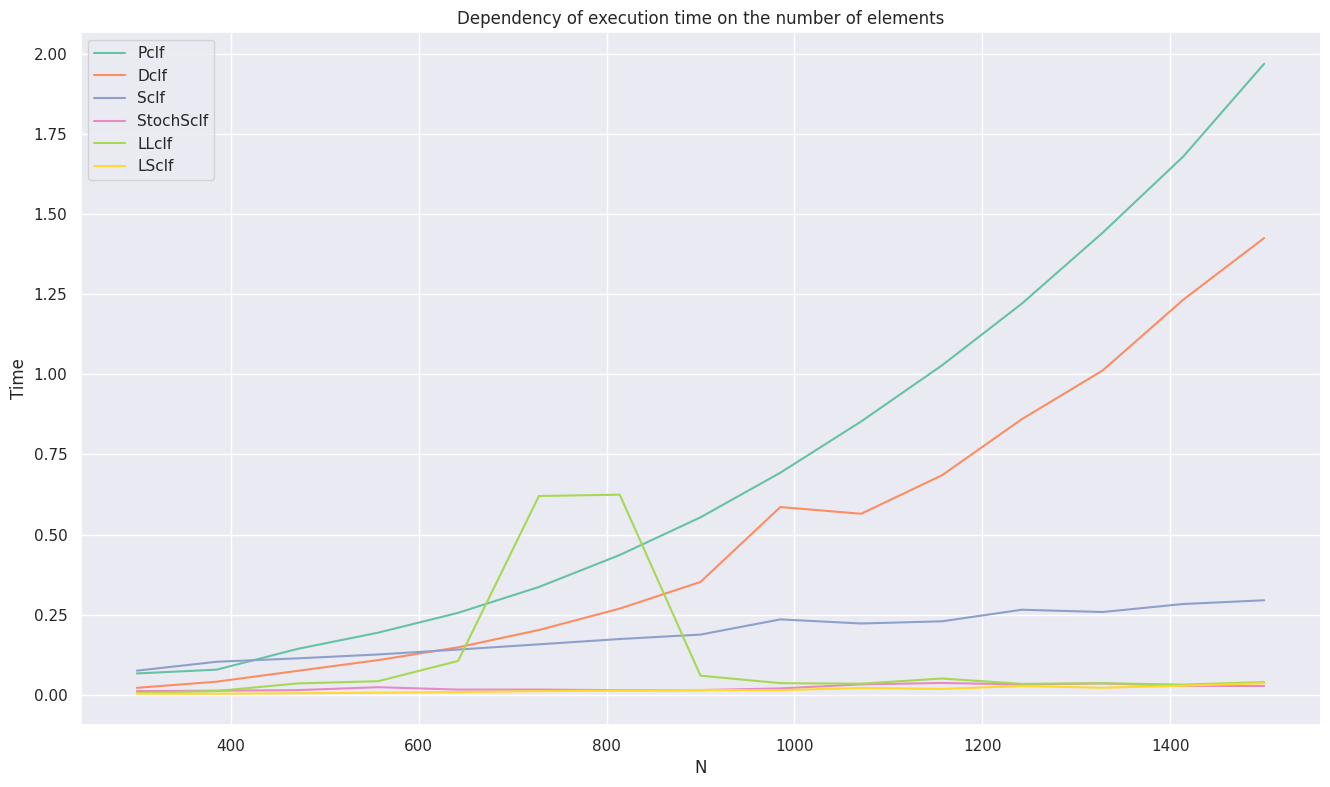

In [7]:
axs = make_plot("N", "Time", "Dependency of execution time on the number of elements")[1]
for key, val in times.items():
    sns.lineplot(x=N_array, y=val, label=key)
plt.show()

__Ваше решение__ 

Опишите наблюдаемые на графиках результаты. Как думаете, почему они такие?
1) Метод внутренней точки для прямой задачи подразумевает зависимость от $n$ так как это прямая задача. В силу матричных операций зависисмость выходит как минимум квадратичная, вследствие чего мы видим быстрый рост затраченного времени
2) Решение двойственной задачи подразумевает переход от исходных переменных к двойственным, попутно требуя решить задачу поиска экстремума. В том числе все вычисления при решении двойственной задачи завязаны на количестве данных $n$, из-за чего время работы тоже растет очень быстро, отличаясь разве что на небольшую константу, но асимптотически оставаясь таким же
3) Субградиентный спуск для решения прямой задачи тратит существенно меньше времени в силу отсутствия прямого перемножения и итераций с полными матрицами большой размерности (мы все так же зависим от $n$, но теперь зависимость превращаетсся в более приближенную к линейной)
4) Метод стохастической оптимизации для решения прямой задачи уже делит на батчи и избавляется от большого множителя $n$, заменяя ее на размер батча, потому работает существенно быстрее
5) Предполагаю, что методы из библиотек очень хорошо оптимизированы и потому дают результаты по скорости сильно лучше, чем уже перечисленныем методы, из-за чего выполнение приближенной минимизации и разбиеня на ряд наименьших возможных задач находятся среди лидеров по скорости. Но стохастическая оптимизация в данном случае им не уступает, так как теперь у нас по сути все параметры в нй являются константами

# Введение в решение нелинейных задач классификации.
Порой бывает так, что данное нам множество не может быть линейно отделимо, но нам все еще хочется использовать SVM для решения задачи. Как в таком случае быть? 

Нужно найти способ из нелинейного множества сделать линейное! В этом нам могут помочь преобразование в другое пространство (возможно с большей размерностью) с помощью ядер. Это помогает из изначальных данных сделать линейно-отделимые.

Приведем примеры нескольких ядер:
1) линейное - $K(x, y) = x^T y$
2) полиномиальное - $K(x, y) = (x^Ty + r)^p$, $\quad r \geqslant 0, q \geqslant 1$
3) радиальное базисное (RBF) - $K(x, y) = \exp(-\lambda ||x - y||^2)$, $\quad \lambda > 0$
4) сигмоидное $K(x, y) = \tanh (\beta_0 x^Ty + \beta_1)$

В этом случае двойственная задача решается следующим образом:

$$
    -\sum_{i=1}^d \lambda_i + \frac{1}{2}\sum_{i=1}^{d}\sum_{j=1}^{d} \lambda_i\lambda_j y_iy_j K(x_i, x_j) \rightarrow \min_{\lambda}\\
    s.t. \quad 0 \leqslant \lambda_i \leqslant C, \quad i = 1,...,d;\\
    \sum_{i=1}^d \lambda_iy_i = 0
$$

__Задача 2. (всего 2.5 балла)__ Сравнение различных способов нахождения решения нелинейных задачи.

В библиотеке реализованы следующие методы решения нелинейной задачи с использованием RBF ядра.
1) Метод внутренней точки для решения двойственной задачи
2) Метод libsvm из библиотеки libsvm (решает задачу оптимизации путем разбиения задачи на ряд наименьших возможных подзадач, которые затем решаются аналитически)

__Hint__ Т.к. задача генерации $n$-мерных шаров трудна, то будет сравнивать работу на линейной задачи. Это все равно не отражается на результатах.

__а). (1 балл)__ Сравнение временной сложности алгоритмов с RBF ядром в зависимости от размерности. 

В этой задаче вам предстоит выбрать размерности, на которых будут сравниваться методы, и вывести на график зависимость времени работы от размерности задачи.

Рекомендуем выбрать как минимум 10 различных размерностей из отрезка [10, 2000].

In [25]:
models = {'Dclf': SVM(method='dual', kernel='linear'),
          'LSclf': SVM(method='libsvm', kernel='linear'),
          'Dclf RBF': SVM(method='dual', kernel='rbf', gamma=0.1),
          'LSclf RBF': SVM(method='libsvm', kernel='rbf', gamma=0.1)}

times = {'Dclf': [],
         'LSclf': [],
         'Dclf RBF': [],
         'LSclf RBF': []}

N = 300  # рекомендуемое количество n_samples в генерации датасета
D_array = np.linspace(10, 2000, 15).astype('int')  # размерности задач

# добавьте сохранение времени рана для каждого из методов
for D in D_array:
    X, y = generate_dataset(N, D)
    y = y[:, np.newaxis]

    for key, val in models.items():
        times[key].append(get_time(val, X, y))

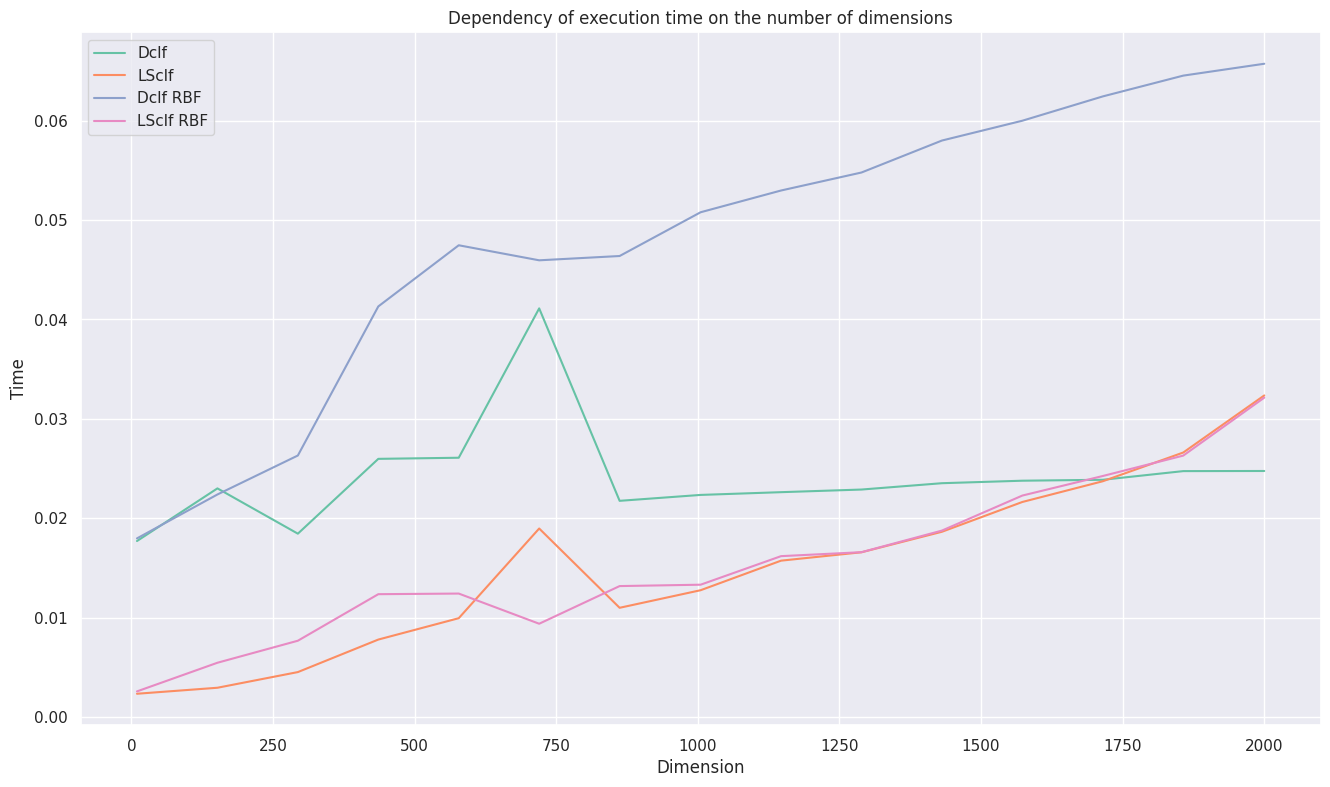

In [26]:
axs = make_plot("Dimension", "Time", "Dependency of execution time on the number of dimensions")[1]
for key, val in times.items():
    sns.lineplot(x=D_array, y=val, label=key)
plt.show()

__Ваше решение__ 

Опишите наблюдаемые на графиках результаты. Как думаете, почему они такие?

Также сравните результаты с решением линейной задачи без использования ядра.

1) Метод решения двойственной задачи при малых $d$ проигрывает, так как не зависит от $d$ и зависит от $n$ (константа больше по сравнению с методом из библиотеки), но на больших начинает выигрывать в силу растущей зависимости от $d$.
2) Метод разбиения задачи на подзадачи почти не отличается по времени при использовании и неиспользовании ядра в силу внутренных оптимизированных вычислений с ядром и того, что от разбиения на задачи при навешивании ядра сложность не меняется с ростом $d$ при фиксированном разбиении и размере данных
3) Ядро в случае вычисления двойственой задачи же начинает нагружать и делать алгоритм чувствительным к $d$, так как зависимость усложняется за счет дополнительных операций. При этом зависимость менее резкая в силу оптимизации внутренних операций, а не использования внешнего ядра

__б). (1.5 балла)__ Сравнение временной сложности решения задач c RBF ядром в зависимости от количества элементов. 

В этой задаче вам предстоит выбрать количество элементов в датасете, на котором будут сравниваться методы, и вывести на график зависимость времени работы от количества элементов в датасете.

Рекомендуем выбрать как минимум 10 различных значений из отрезка [300, 1500].

In [27]:
models = {'Dclf': SVM(method='dual', kernel='linear'),
          'LSclf': SVM(method='libsvm', kernel='linear'),
          'Dclf RBF': SVM(method='dual', kernel='rbf', gamma=0.1),
          'LSclf RBF': SVM(method='libsvm', kernel='rbf', gamma=0.1)}

times = {'Dclf': [],
         'LSclf': [],
         'Dclf RBF': [],
         'LSclf RBF': []}

D = 200  # рекомендуемая размерность задачи
N_array = np.linspace(300, 1500, 15).astype('int')

# добавьте сохранение времени рана для каждого из методов
for N in N_array:
    X, y = generate_dataset(N, D)
    y = y[:, np.newaxis]

    for key, val in models.items():
        times[key].append(get_time(val, X, y))

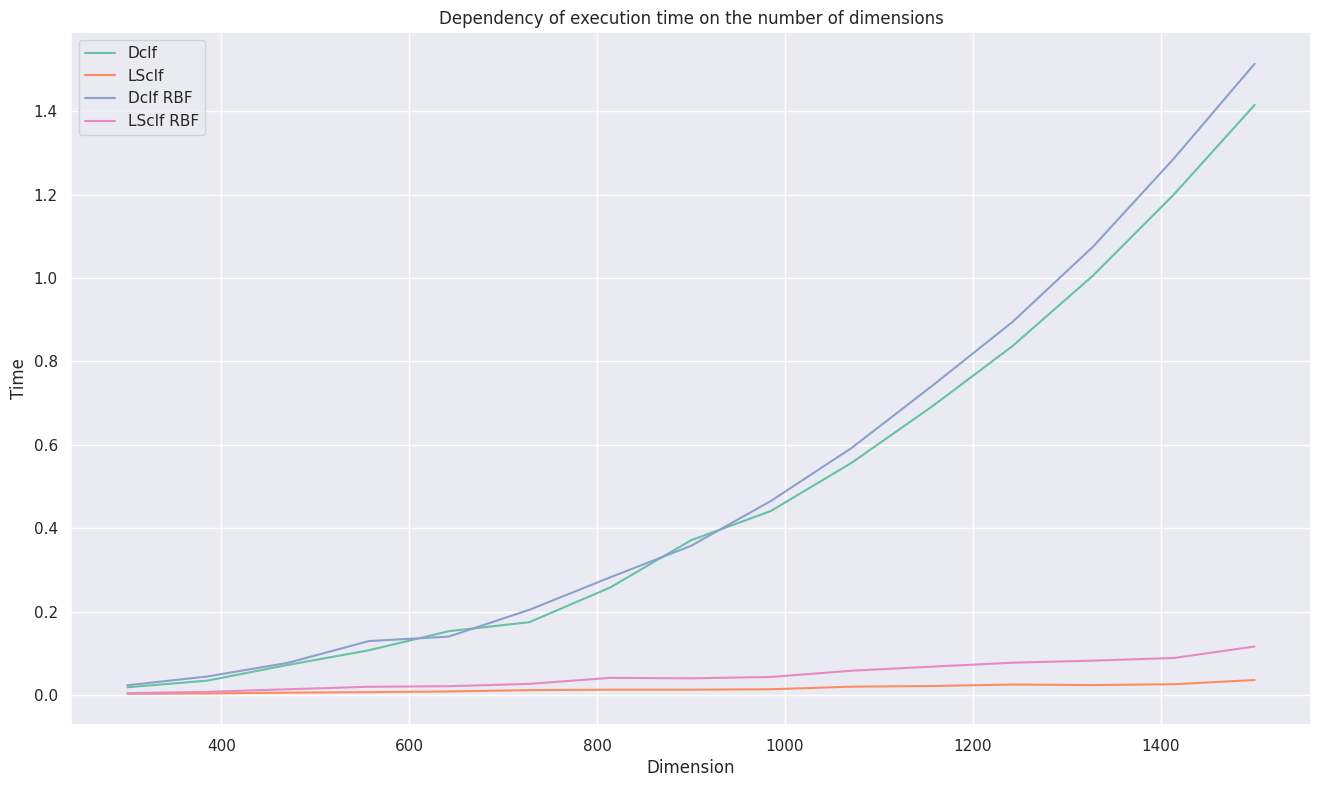

In [28]:
axs = make_plot("Dimension", "Time", "Dependency of execution time on the number of dimensions")[1]
for key, val in times.items():
    sns.lineplot(x=N_array, y=val, label=key)
plt.show()

__Ваше решение__ 

Опишите наблюдаемые на графиках результаты. Как думаете, почему они такие?

Также сравните результаты с решением линейной задачи без использования ядра.

1) Использование ядра в случае двойственной задачи практически никак не зависит от роста количества данных, так как ядро навешивается на атомарные вычисления и прибавляет разве что константу в конце суммирования
2) При использовании разбиения задачи на подзадачи время работы с ядром увеличивается более чам в 2 раза исходя из графика. Это происходит, так как вычислять ядро нам требуется сильно больше, для каждой подзадачи
3) По уже описанным причинам в прошлой части метод решения двойственной задачи проигрывает

## Дополнительная часть

Рассмотрим двойстеннцю задачу с RBF ядром подробнее, запишем ее:

$$
    -\sum_{i=1}^d \lambda_i + \frac{1}{2}\sum_{i=1}^{d}\sum_{j=1}^{d} \lambda_i\lambda_j y_iy_j \exp(-\lambda ||x - y||^2) \rightarrow \min_{\lambda}\\
    s.t. \quad 0 \leqslant \lambda_i \leqslant C, \quad i = 1,...,d;\\
    \sum_{i=1}^d \lambda_iy_i = 0
$$

Как можно видеть, есть два гиперпараметра - $C, \lambda$. В этой части задания мы подберем лучшие значения этих гиперпараметров для двух задач.

__Задача 1. (всего 5 баллов)__ Подбор гиперпараметров для хорошо и плохо разделимой выборки. Сравнение результатов.

### Хорошо разделимая выборка

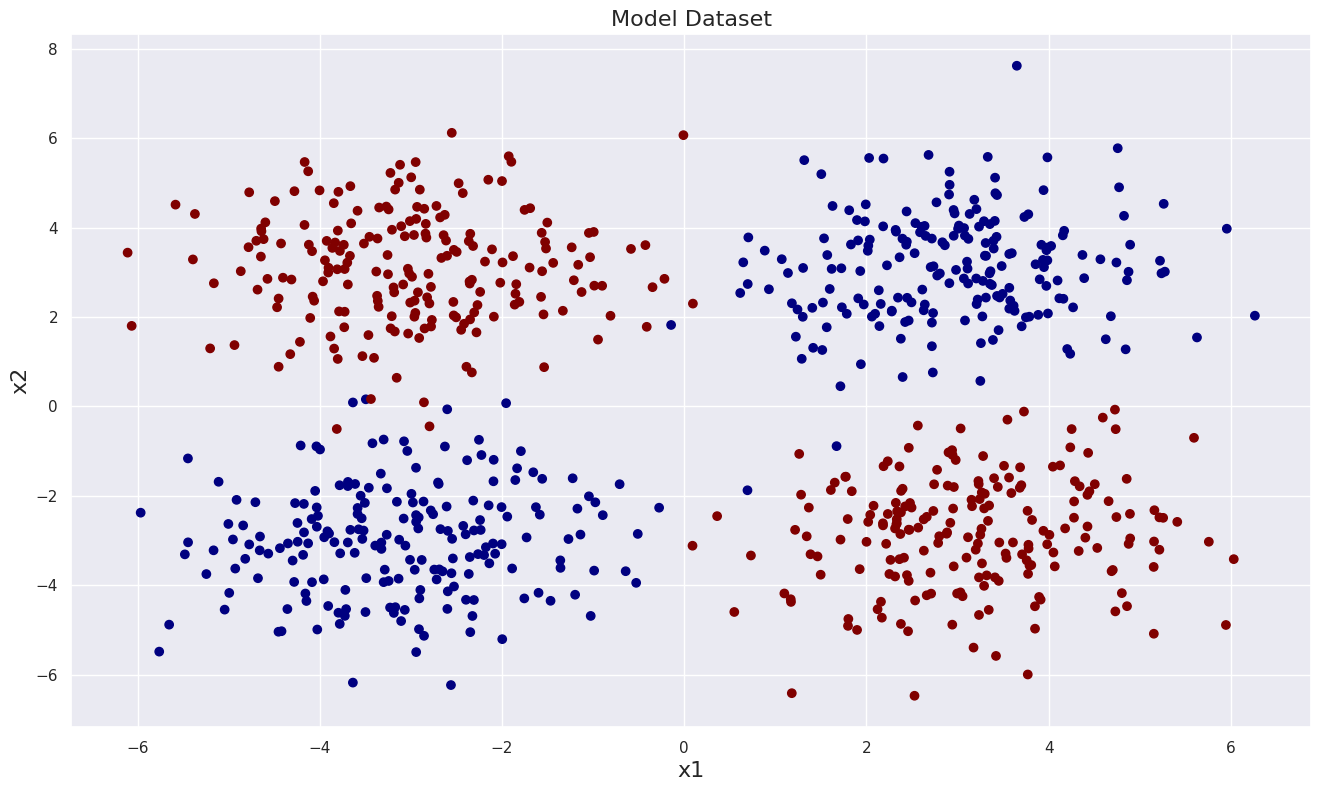

In [12]:
N = 800
D = 2
batch = N // 4
dataset = np.zeros((N, D))

np.random.seed(42)

dataset[:, 0][:batch] = np.random.normal(loc=3, scale=1.2, size=batch)
dataset[:, 1][:batch] = np.random.normal(loc=3, scale=1.2, size=batch)
dataset[:, 0][batch: 2 * batch] = np.random.normal(loc=-3, scale=1.2, size=batch)
dataset[:, 1][batch: 2 * batch] = np.random.normal(loc=-3, scale=1.2, size=batch)
dataset[:, 0][2 * batch: 3 * batch] = np.random.normal(loc=3, scale=1.2, size=batch)
dataset[:, 1][2 * batch: 3 * batch] = np.random.normal(loc=-3, scale=1.2, size=batch)
dataset[:, 0][3 * batch:] = np.random.normal(loc=-3, scale=1.2, size=batch)
dataset[:, 1][3 * batch:] = np.random.normal(loc=3, scale=1.2, size=batch)
target = -np.ones((N, 1), dtype=np.int32)
target[2 * batch:, 0] = 1

plt.close()
plt.scatter(dataset[:, 0], dataset[:, 1], c=target, cmap=plt.cm.jet)
plt.title('Model Dataset', fontsize=16)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.show()

__а). (1 балл)__ Допишите недостающий код. Функция должна сохранять лучшее занчение mean accuracy, а также гиперпараметры gamma и C для этого лучшего значения.

In [13]:
def BruteSearchCV(X, y, method, C_list, gamma_list):
    best_mean_accuracy = -1.0
    best_gamma = -1.0
    best_C = -1.0
    results = []
    cv = KFold(n_splits=7, shuffle=True, random_state=42)
    for gamma in gamma_list:
        for C in C_list:
            clf = svm.SVM(C=C, method=method, kernel='rbf', gamma=gamma)
            acc_list = []
            for train_index, test_index in cv.split(X, y):
                X_train, X_test = X[train_index, :], X[test_index, :]
                y_train, y_test = y[train_index, :], y[test_index, :]
                clf.fit(X_train, y_train)
                acc_list.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test, return_classes=True).T[0]))
            mean_acc_score = np.array(acc_list).mean()
            if mean_acc_score > best_mean_accuracy:
                best_mean_accuracy = mean_acc_score
                best_gamma = gamma
                best_C = C
            results.append({'mean_accuracy': mean_acc_score, 'gamma': gamma, 'C': C})
    return {'best_mean_accuracy': best_mean_accuracy, 'best_gamma': best_gamma, 'best_C': best_C}, results

__б). (1 балл)__ Допишите недостающий код запуска поиска с методами 'dual' и 'libsvm'.

In [14]:
gamma_list = 10.0 ** np.arange(-5, 6)
C_list = 10.0 ** np.arange(-5, 6)
dual_best, dual_table = BruteSearchCV(dataset, target, 'dual', C_list, gamma_list)
libsvm_best, libsvm_table = BruteSearchCV(dataset, target, 'libsvm', C_list, gamma_list)

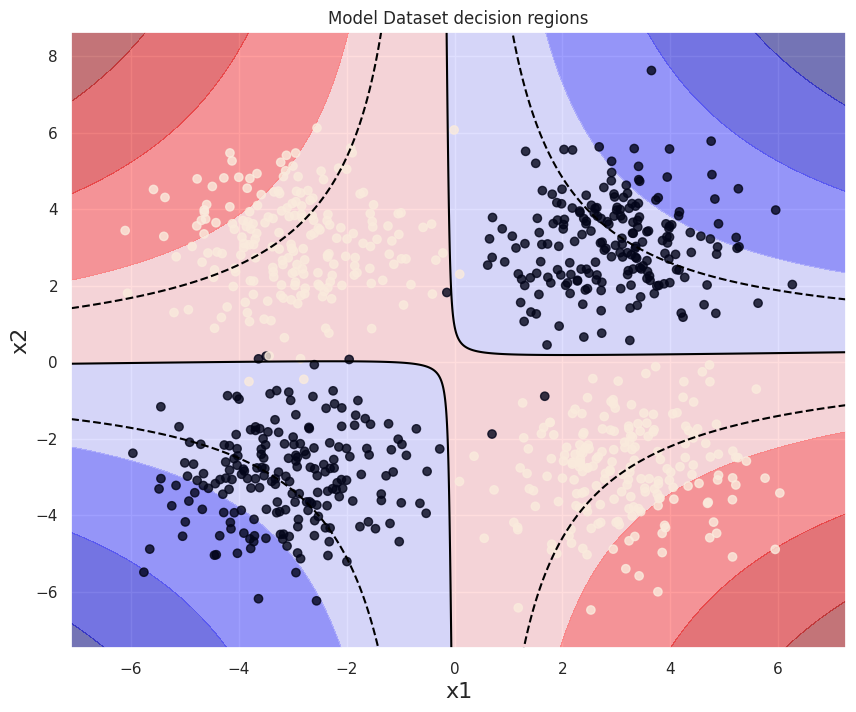

In [15]:
clf = SVM(method='libsvm', C=libsvm_best['best_C'], kernel='rbf', gamma=libsvm_best['best_gamma'])
clf.fit(dataset, target)
visualize(dataset, target, clf, show_vectors=True, title='Model Dataset decision regions',
          return_classes=False)

Results for dual method:


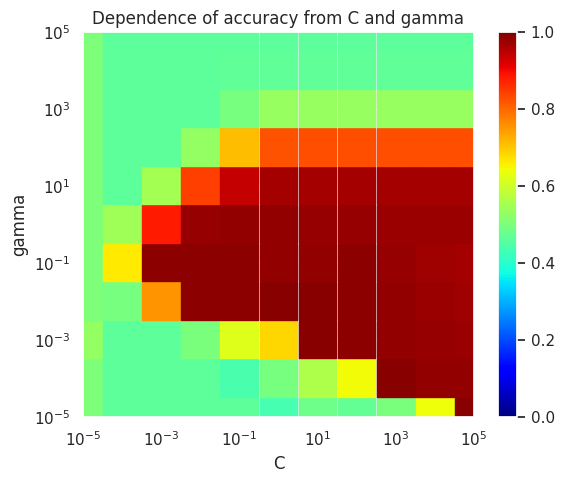

In [16]:
dual_table = pd.DataFrame(dual_table)
libsvm_table = pd.DataFrame(libsvm_table)

plt.close()
plt.figure(figsize=(6.3, 5))
xx2 = dual_table.gamma
xx1 = dual_table.C
accuracy_mesh = dual_table.mean_accuracy
sc = plt.scatter(xx1, xx2, c=accuracy_mesh, cmap=plt.cm.jet, s=740, vmin=0.0, vmax=1.0, marker='s')
plt.title('Dependence of accuracy from C and gamma', fontsize=12)
plt.xlabel('C', fontsize=12)
plt.ylabel('gamma', fontsize=12)
plt.xlim([C_list.min(), C_list.max()])
plt.ylim([gamma_list.min(), gamma_list.max()])
plt.xscale('log')
plt.yscale('log')
plt.colorbar(sc)
print('Results for dual method:')
plt.show()

### Плохо разделимая выборка

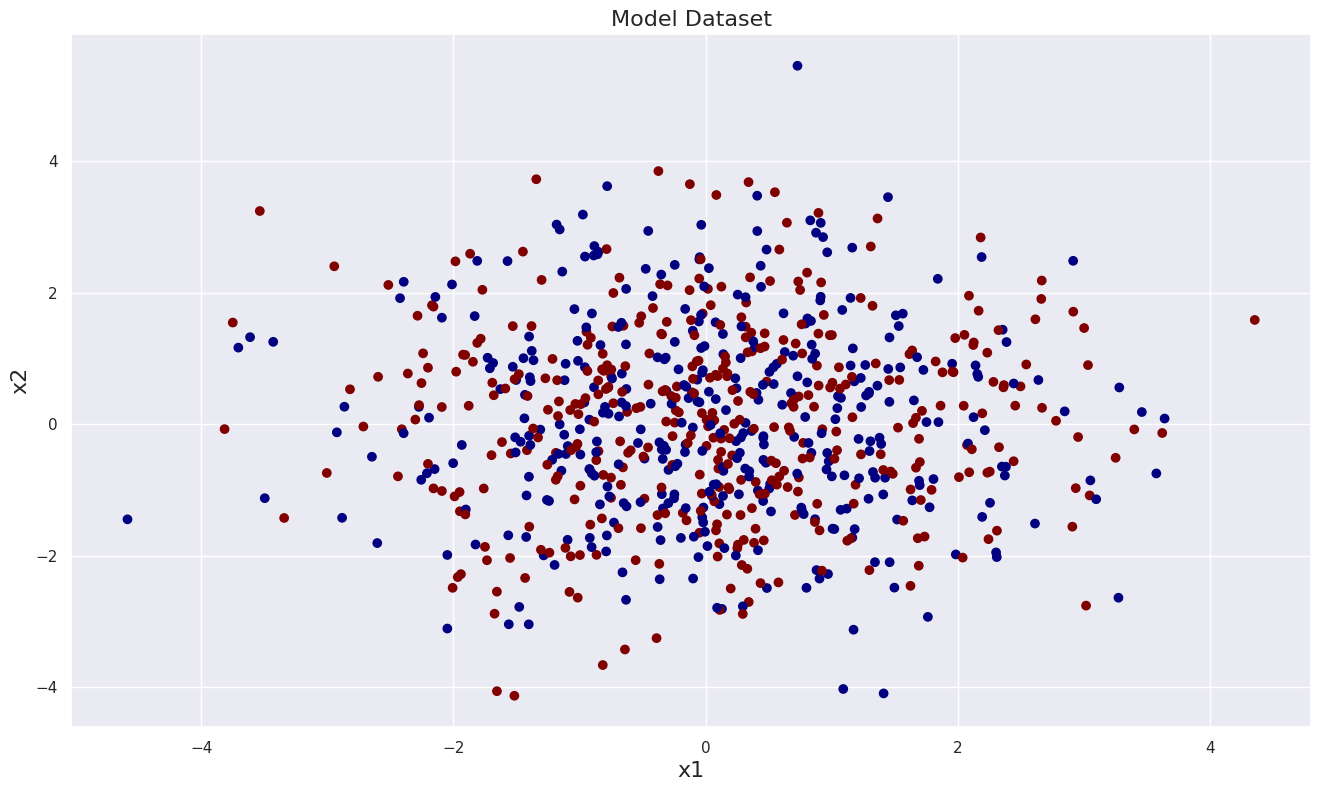

In [17]:
N = 800
D = 2

np.random.seed(42)

means = np.zeros(D)
covs = 2 * np.diag(np.ones(D))
dataset = np.random.multivariate_normal(means, covs, N)
batch = N // 2
target = np.random.choice([1, -1], size=N)[:, np.newaxis]
plt.close()
plt.scatter(dataset[:, 0], dataset[:, 1], c=target, cmap=plt.cm.jet)
plt.title('Model Dataset', fontsize=16)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.show()

In [18]:
gamma_list = 10.0 ** np.arange(-5, 6)
C_list = 10.0 ** np.arange(-5, 6)
dual_best, dual_table = BruteSearchCV(dataset, target, 'dual', C_list, gamma_list)
libsvm_best, libsvm_table = BruteSearchCV(dataset, target, 'libsvm', C_list, gamma_list)
table = {'dual': dual_best, 'libsvm': libsvm_best}

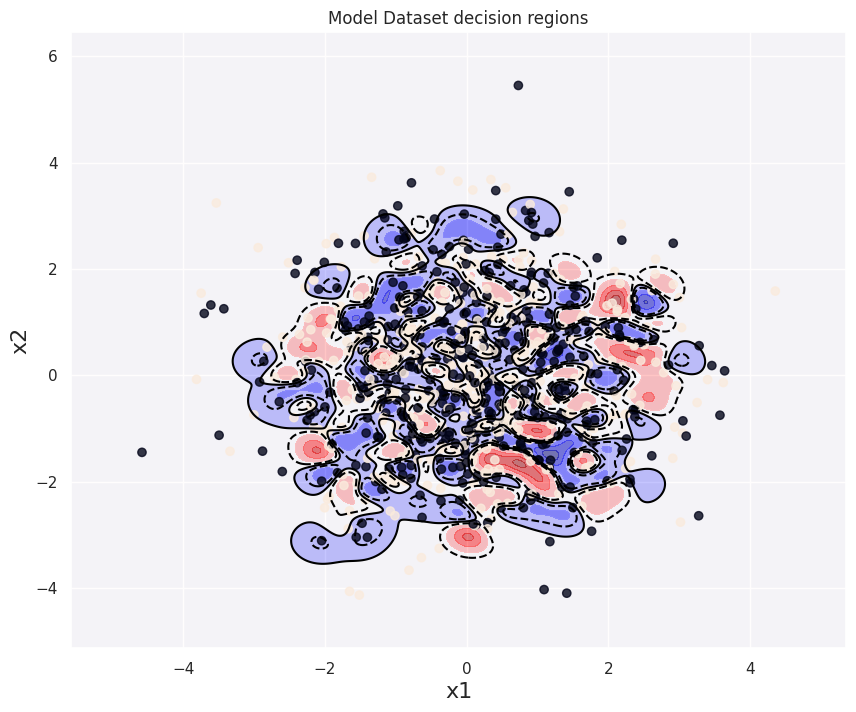

In [19]:
clf = SVM(method='libsvm', C=libsvm_best['best_C'], kernel='rbf', gamma=libsvm_best['best_gamma'])
clf.fit(dataset, target)
visualize(dataset, target, clf, show_vectors=True, title='Model Dataset decision regions',
          return_classes=False)

Results for dual method:


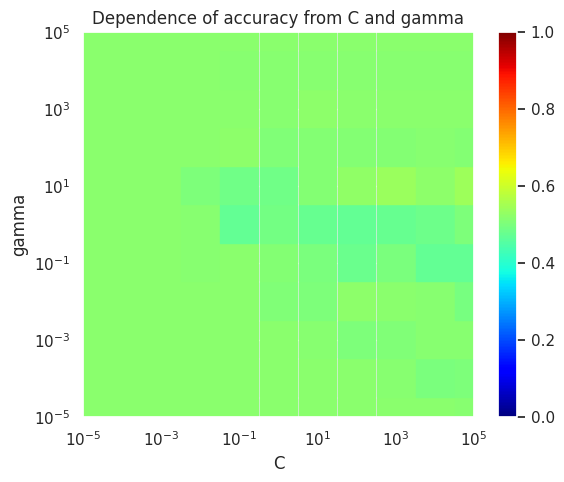

In [20]:
dual_table = pd.DataFrame(dual_table)
libsvm_table = pd.DataFrame(libsvm_table)

plt.close()
plt.figure(figsize=(6.3, 5))
xx2 = dual_table.gamma
xx1 = dual_table.C
accuracy_mesh = dual_table.mean_accuracy
sc = plt.scatter(xx1, xx2, c=accuracy_mesh, cmap=plt.cm.jet, s=740, vmin=0.0, vmax=1.0, marker='s')
plt.title('Dependence of accuracy from C and gamma', fontsize=12)
plt.xlabel('C', fontsize=12)
plt.ylabel('gamma', fontsize=12)
plt.xlim([C_list.min(), C_list.max()])
plt.ylim([gamma_list.min(), gamma_list.max()])
plt.xscale('log')
plt.yscale('log')
plt.colorbar(sc)
print('Results for dual method:')
plt.show()

__в). (3 балла)__ Посмотрите на зависмость точности от различных $C$ и $\gamma$. Напишите почему так происходит, подкрепите свои рассуждения необходимыми выкладками.  

__Ваше решение__

#### Хорошо разделимая выборка

1) Гиперпараметр $C$ контролирует баланс между сложностью модели и количеством ошибок на обучающей выборке. 
Большие значения $C$ штрафуют за ошибки на обучающей выборке, что приводит к переобученнию модели и она подстраивается под шум в данных. 
Маленькие значения $C$ упрощают модель, что может приводить к недообучению: она плохо разделяет нетривиальные данные и работает на минимизацию параметров, так как сильно ограничиваются сверху $\lambda$.
Малые значения 

2) Гиперпараметр $\gamma$ определяет "радиус влияния" каждого обучающего примера. 
Большие значения $\gamma$ приводят к тому, что модель вновь становится сильно нелинейной и начинает подстраиваться под шум в данных в силу большого штрафа за ошибку.
При маленьких значенияъ RBF ядро становится близким к линейному, что ухудшает работу модели на не совсем трвииальных множествах.

Поэтому мы получили зависимость, где наилучший результат достигается, в "золотой середине", причем с ростом $C$ нижняя граница параметра $\gamma$ уменьшается в силу ослабления верхней границы на парметры. 
Во всех остальных (зеленых) областях мы получаем, что модели лучше сказать тождественную функцию, так как оан даст более хороший результат (неверный подбор гиперпараметров).

#### Плохо разделимая выборка

При совсем плохо разделяемой выборке модели просто не хватает возможностей, чтобы явно определить границы, а у нас она как раз-таки случайна.
Более того, так как у нас классы распределены равномерно, то данные принципиально неразделимы - в таком случае никакая модель не сможет построить границу разделения, которая даст точность выше случайного угадывания, при этом не подсроившись полностью под данные и не переобучившись.
И даже если модель адаптируется к шуму (при высоких значениях гиперпараметров), на нашей выборке она всё равно не сможет обобщить из-за случайного характера данных.
Так как выборка сбалансирована (количество объектов каждого класса одинаковое), то мы получаем, что точность везде примерно равна $0.5$ - это и есть случайное угадывание, превзойти котороое не поможет никакой подбор гиперпараметров.